In [1]:
from IPython import get_ipython
try:
    import geemap
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print('package not found, installing w/ pip in Google Colab...')
        !pip install geemap
    else:
        print('package not found, installing w/ pipenv...')
        !pipenv install geemap
    import geemap

In [2]:
import ee

In [3]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

<AxesSubplot:>

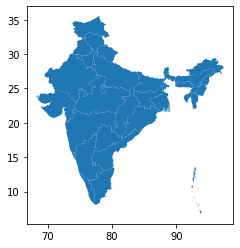

In [4]:
india_shape = "../data/gadm/gadm36_IND_1.shp"
import geopandas as gpd
import matplotlib.pyplot as plt
import sys 
sys.path.insert(0, '../src/')
%matplotlib inline
india_gpd = gpd.read_file(india_shape)
india_gpd.plot()


<AxesSubplot:>

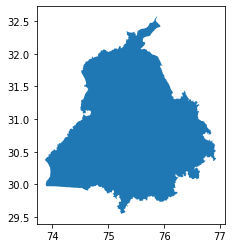

In [5]:
# Extract a specific state of india by name
import extract_gadm_data as egd

punjab_gdf = egd.extract_state_dataframe(india_gpd, 'Punjab')
punjab_gdf.plot()

In [6]:
# Compute the extents of Punjab
punjab_extents = egd.region_extents(punjab_gdf)
print(punjab_extents)

(73.87088776, 29.54617119, 76.93139648, 32.57619095)


In [7]:
punjab_bbox = egd.get_region_bounding_box(punjab_extents)
punjab_polygon = ee.Geometry.Polygon([[list(punjab_bbox[0]), list(punjab_bbox[1]), list(punjab_bbox[2]), list(punjab_bbox[3]), list(punjab_bbox[0])]])


# Load the Sentinel-1 Image Collection, filter to Jun-November 2020 observations and bounded by bounding box for Punjab
punjab_sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate('2020-06-01', '2020-11-01').filterBounds(punjab_polygon)

In [8]:
# Filter the Sentinel-1 collection of Punjab by metadata properties
punjab_VhIw = punjab_sentinel1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).filter(ee.Filter.eq('instrumentMode', 'IW'))

In [9]:
# Separate ascending and descending orbit images into distinct collections.
punjab_VhIw_asc = punjab_VhIw.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
punjab_VhIw_desc = punjab_VhIw.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

In [ ]:
# Calculate temporal means for various observations to use for visualisation
# Meah VH ascending
pb_vhIw_asc_mean = punjab_VhIw_asc.select('VH').mean()
pb_vhIw_desc_mean = punjab_VhIw_desc.select('VH').mean()